# Progetto 2021 
**Barbara Vito 214254**

**Bellusci Pierpaolo 214244**

In [ ]:
SEED = 9246
import glob
import os
import json
import time
from datetime import datetime
import collections
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import random
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support
from skimage import io
import pandas as pd
import numpy as np
np.random.seed(SEED)
random.seed(SEED)
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report,precision_score

import torchsummary

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CUDA = torch.cuda.is_available()
device = torch.device("cuda" if CUDA else "cpu")


#Costanti

In [ ]:
DRIVE_FOLDER = 'drive/MyDrive/ComputerVision/progetto_2021/'
LABELED_DATASET_DIR = 'labeled_dataset/'
MINI_LABELED_DATASET_DIR = 'mini_labeled_dataset/'
UNLABELED_DATASET_DIR = 'unlabeled_dataset1/'
BATCH_SIZE = 32
LIMIT=20

# Funzioni Utilità

In [ ]:
def showImage(x):
    x = x.permute((1,2,0))
    plt.figure()
    plt.imshow(x)
    plt.show()

def showFrames(frames,denormalize=True):
    plt.figure(figsize=(20,20))
    
    for k,x in enumerate(frames):
        plt.subplot(6,len(frames)//6+1,k+1)
        plt.axis('off')
        x = x.numpy().transpose((1,2,0))
        if denormalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            x = std * x + mean
        x = np.clip(x,0,1)
        plt.imshow(x)
    
    plt.show()

def test(net,img_size=32,input_channel=3):
    x = torch.randn(1,input_channel,img_size,img_size)
    y = net(x)
    print("Input: {}; Output: {}; ".format(list(x.size()), list(y.size())))

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def removeSameModels(folder,name):
    fileModels = os.listdir(folder)
    for x in fileModels:
        if name == x.split("_")[0]:
            delete_filename = folder+x
            open(delete_filename, 'w').close() 
            os.remove(delete_filename)

def save_checkpoint(epoch, model, optimizer, loss,name="model",history = [],optimizer2 = None): 
    removeSameModels(os.path.join(DRIVE_FOLDER, f'checkpoints/'),name)
    
    CHECKPOINT = os.path.join(DRIVE_FOLDER, f'checkpoints/{name}_{epoch}.checkpoint')
    d = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'history': history,
            }
    if optimizer2 != None:
        d['optimizer_state_dict2'] = optimizer2.state_dict()
    torch.save(d, CHECKPOINT)


def load_checkpoint(model, optimizer,epoch,name="model",optimizer2=None): 
    CHECKPOINT = os.path.join(DRIVE_FOLDER,f'checkpoints/{name}_{epoch}.checkpoint')

    if not os.path.exists(CHECKPOINT):
        return None, None
    checkpoint = torch.load(CHECKPOINT)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer!= None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    history = checkpoint.get('history',[])
    if optimizer2 !=None:
        optimizer2.load_state_dict(checkpoint['optimizer_state_dict2'])

    return epoch, loss, history

def save_model(model):
    MODELFILE = os.path.join(DRIVE_FOLDER, 'model.pth')
    torch.save(model.state_dict(), MODELFILE)

def load_lodel(model):
    MODELFILE = os.path.join(DRIVE_FOLDER, 'model.pth')
    if os.path.exists(MODELFILE):
        model.load_state_dict(torch.load(MODELFILE))

# Load Data

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if not os.path.isdir("labeled_dataset"):

    labeled_dataset_rar = os.path.join(DRIVE_FOLDER,"datasets/progetto_2021_dataset_labeled.tgz") 
    !tar -xf {labeled_dataset_rar}     
    !mv progetto_2021_dataset labeled_dataset

print("Labeled file ready")

if not os.path.isdir("unlabeled_dataset1"):
    unlabeled_dataset1_rar = os.path.join(DRIVE_FOLDER,"datasets/progetto_2021_dataset_UNlabeled1.tgz") 
    !tar -xf {unlabeled_dataset1_rar}
    !mv progetto_2021_dataset/unlabeled1 unlabeled_dataset1
    !rm -rf progetto_2021_dataset

print("Unlabeled file ready")

lab_dataset_dir=LABELED_DATASET_DIR

Labeled file ready
Unlabeled file ready


In [ ]:
JSON_DATA = os.path.join(lab_dataset_dir, 'train_test_split_dict.json')

with open(JSON_DATA) as fp:
    dataset_json = json.load(fp)

In [ ]:
labels = set()

for k in dataset_json.values():
    for lable_list in k.values():
        for v in lable_list:
            labels.add(v)
            
label_idx = {v: i for i, v in enumerate(sorted(labels))}

id_label = {v: i for i, v in label_idx.items()}

# Data Understanding

In [ ]:
def plotBarChart(x,y, offsetY=0, xLabel="x", yLabel="y", yLimMax = None,title=""):
    plt.figure(figsize=(20,5))
    plt.bar(x, y, align='center', width=0.8)

    plt.title(title,fontsize=16,fontweight='bold')

    plt.xlabel(xLabel, fontsize=16)
    plt.ylabel(yLabel, fontsize=16)

    for index, value in enumerate(y):
        plt.text(index, value+offsetY, str(value), fontweight='bold',fontsize=12, ha='center', va='bottom',rotation=90 )

    plt.xticks(range(len(x)), x, rotation=90 ,fontsize=14)

    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

    if yLimMax == None:
        maxY = y[np.argmax(y)]
        plt.ylim(0, maxY*1.2)
    else:
        plt.ylim(0, yLimMax)
    plt.show()

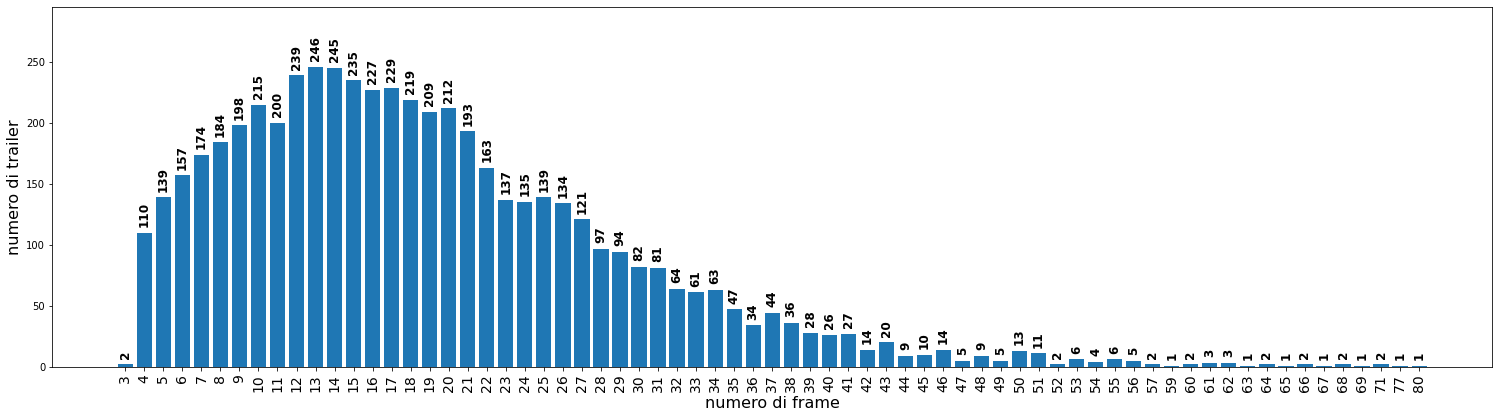

In [ ]:
files = os.listdir(lab_dataset_dir)

cont=0
dic = {}
for x in files:
    if '.json' not in x:
        #print(x)
        leng = len(os.listdir(os.path.join(lab_dataset_dir,x)))
        if leng not in dic:
            dic[leng]=0
        dic[leng] +=1  


dic = dict(sorted(dic.items(), key=lambda item: item[0]))
nOfFrames = [*map(str,dic.keys())]
occurences = list(dic.values())
plotBarChart(nOfFrames,occurences,offsetY=5, xLabel="numero di frame", yLabel="numero di trailer")

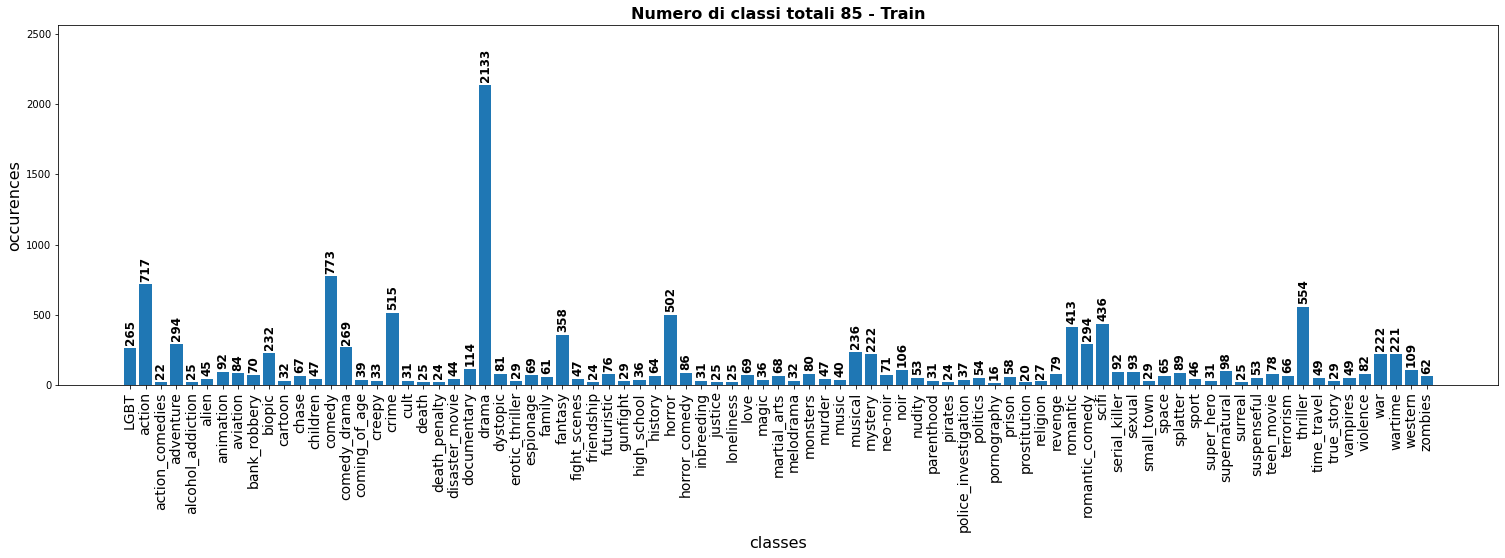

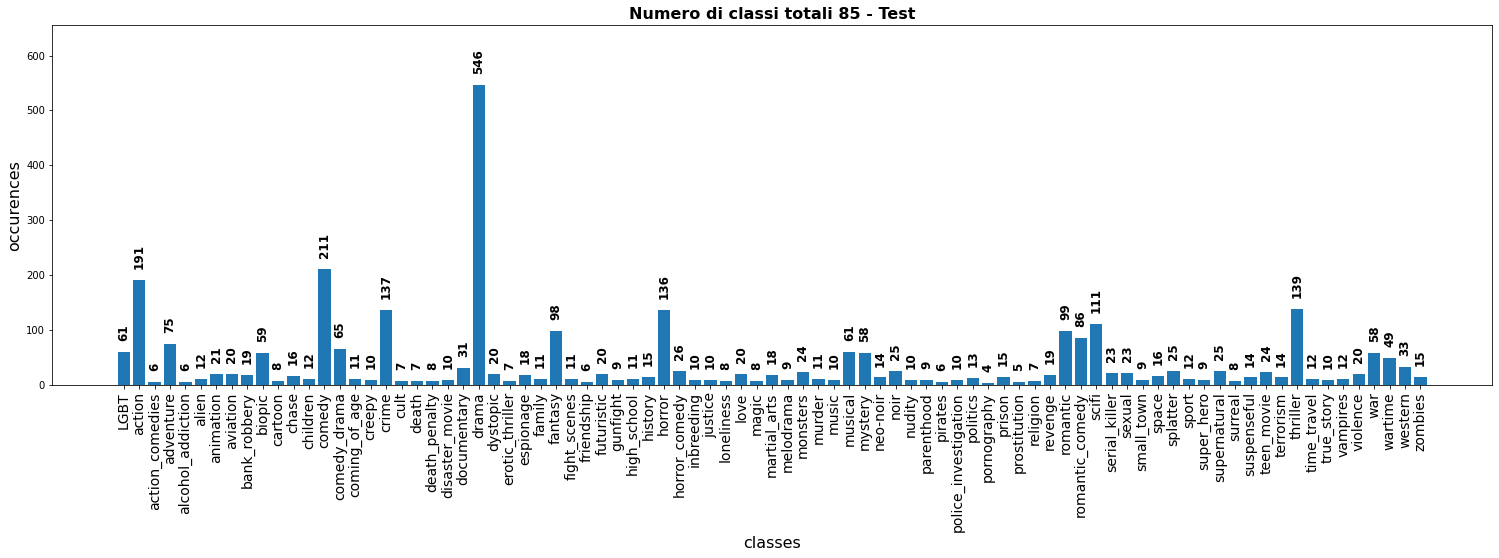

In [ ]:
classes = {k:0 for k in label_idx.keys() }
trainset = dataset_json['train']
testset = dataset_json['test']

for item in trainset:
    for l in trainset[item]:
        classes[l]+=1

plotBarChart(classes.keys(), list(classes.values()), offsetY=20, xLabel='classes',title=f"Numero di classi totali {len(classes)} - Train", yLabel='occurences')

classes = {k:0 for k in label_idx.keys() }
for item in testset:
    for l in testset[item]:
        classes[l]+=1

plotBarChart(classes.keys(), list(classes.values()), offsetY=20, xLabel='classes',title=f"Numero di classi totali {len(classes)} - Test", yLabel='occurences')

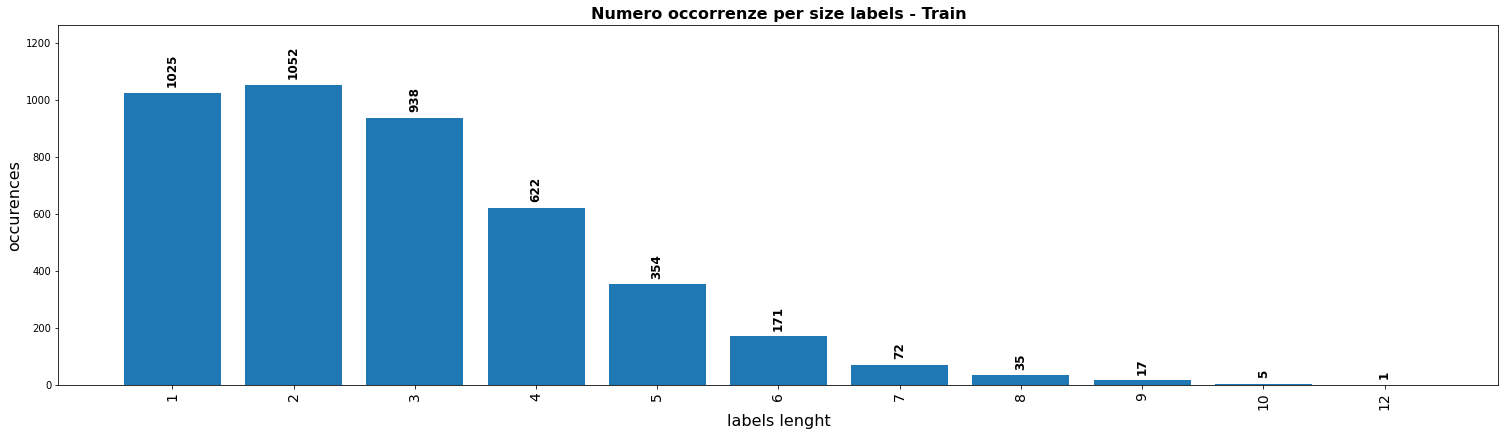

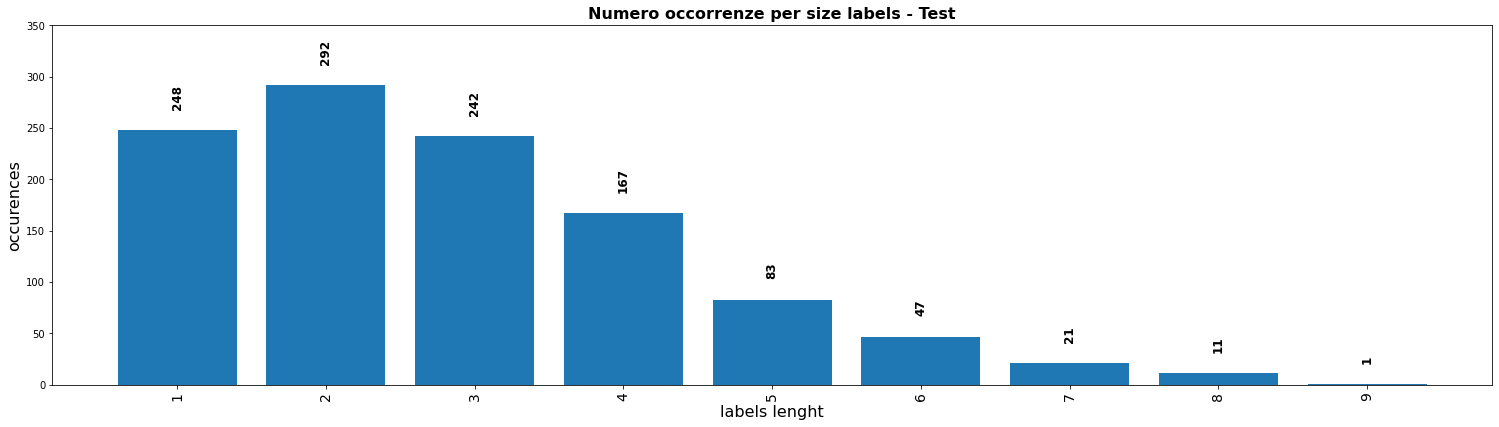

In [ ]:
def occurencesForNOfClasses(dataset):
    classes = {}
    for item in dataset:
        if len(dataset[item]) not in classes:
            classes[len(dataset[item])]=0
        classes[len(dataset[item])]+=1

    dic = dict(sorted(classes.items(), key=lambda item: item[0]))
    nOfClasses = [*map(str,dic.keys())]
    occurences = list(dic.values())
    return nOfClasses, occurences

trainset = dataset_json['train']
testset = dataset_json['test']

nOfClasses, occurences =  occurencesForNOfClasses(trainset)
plotBarChart(nOfClasses,occurences, offsetY=20, xLabel='labels lenght', yLabel='occurences',title=f"Numero occorrenze per size labels - Train")

nOfClasses, occurences =  occurencesForNOfClasses(testset)
plotBarChart(nOfClasses,occurences, offsetY=20, xLabel='labels lenght', yLabel='occurences',title=f"Numero occorrenze per size labels - Test")

# Dataset

In [ ]:
class SesemiTransform:

    classes = ('0', '90', '180', '270', 'hflip', 'vflip')

    def __init__(self,standar_transformations):
        self.standar_transformations = transformations

    def __call__(self, images):
        output = []
        images = self.standar_transformations(images)
        tf_type = random.randint(0, len(self.classes) - 1)
        for x in images:
            if tf_type == 0:
                x = x
            elif tf_type == 1:
                x = torchvision.transforms.functional.rotate(x, 90)
            elif tf_type == 2:
                x = torchvision.transforms.functional.rotate(x, 180)
            elif tf_type == 3:
                x = torchvision.transforms.functional.rotate(x, 270)
            elif tf_type == 4:
                x = torchvision.transforms.functional.hflip(x)
            elif tf_type == 5:
                x = torchvision.transforms.functional.rotate(x, 180)
                x = torchvision.transforms.functional.hflip(x)
        
            output.append(x)
            
        output = torch.stack(output)
        return output, torch.tensor(tf_type,device=device)

class VideoUnlabeledDataset(Dataset):

    def __init__(self, dataset_folder, transform, limit=30):
        
        self.root_dir = dataset_folder
        self.limit = limit
        self.transform = transform
        
        self._files = os.listdir(dataset_folder)

    def __len__(self):
        return len(self._files)

    def __getitem__(self, idx):
        name = self._files[idx]

        png_images = glob.glob(os.path.join(self.root_dir, name, '*.png'),recursive=False)
        
        # each iteration shuffle frames 
        random.shuffle(png_images)

        if len(png_images)>self.limit:
            png_images=png_images[:self.limit]   
                    
        images = [torchvision.io.read_image(i).float()/255 for i in png_images]

        images = torch.stack(images).to(device)


        if images.shape[0]< self.limit:
            images = torch.cat([images,torch.full((self.limit-images.shape[0],*images.shape[1:]),0.0,device=device)],0)
        
        images,label = self.transform(images)

        return images, label

class VideoDataset(Dataset):

    def __init__(self, dataset_folder, labels_dict, transform=None, limit=30,shuffle=True):
        self.labels_dict = labels_dict
        self.root_dir = dataset_folder
        self.limit = limit
        self.transform = transform
        self._files = np.array(list(self.labels_dict.keys()))
        self.shuffle = shuffle

    def __len__(self):
        return len(self.labels_dict)

    def shuffleFiles(self):
        for x in self.folder_files:
            self.folder_files[x] = random.shuffle(self.folder_files[x])
        
    def __shuffleImages(self,png_images):
        if self.shuffle:
            # each iteration shuffle frames 
            random.shuffle(png_images)


    def __getitem__(self, idx):
        name = self._files[idx]
        
        png_images = glob.glob(os.path.join(self.root_dir, name, '*.png'),recursive=False)
        
        self.__shuffleImages(png_images)

        if len(png_images)>self.limit:
            png_images=png_images[:self.limit]   

        images = [(torchvision.io.read_image(i).float()/255) for i in png_images]
        
        images = torch.stack(images).to(device)

        x = self.transform(images)

        if x.shape[0]< self.limit:            
            x = torch.cat([x,torch.full((self.limit-x.shape[0],*x.shape[1:]),0.0,device=device)],0)
            
        labels = torch.zeros(len(label_idx), dtype=torch.float32,device = device)
        for label in self.labels_dict[name]:
            labels[label_idx[label]] = 1
        
        

        return x, labels

In [ ]:
transformations = nn.Sequential(T.Resize((224,224)),
                                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])).to(device)


weak_agu = nn.Sequential( T.RandomRotation(degrees=(-15, 15)),   
                          T.RandomResizedCrop(size=224,scale=(0.8,1.0)),
                          T.RandomHorizontalFlip(p=0.5),
                          T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])).to(device)


 
datasetTrain = VideoDataset(lab_dataset_dir, dataset_json['train'], transform=weak_agu, limit=LIMIT,shuffle=True)
unlabeledDatasetTrain = VideoUnlabeledDataset(UNLABELED_DATASET_DIR , SesemiTransform(transformations),limit=LIMIT)

datasetTest = VideoDataset(lab_dataset_dir, dataset_json['test'], transform=transformations, limit=LIMIT,shuffle=False)

In [ ]:
trainingDataLoader = torch.utils.data.DataLoader(datasetTrain, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=True, 
                                                 num_workers=0)

trainingUnlabeledDataLoader = torch.utils.data.DataLoader(unlabeledDatasetTrain, 
                                                 batch_size=BATCH_SIZE, 
                                                 shuffle=True, 
                                                 num_workers=0)

testDataLoader = torch.utils.data.DataLoader(datasetTest, 
                                             batch_size=BATCH_SIZE, 
                                             shuffle=False, 
                                             num_workers=0)

# Model

In [ ]:
class SesemiClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        pretrained = models.resnet50(pretrained = True)
        self.features_extractor = torch.nn.Sequential(*(list(pretrained.children())[:-1]))
        
        in_features = pretrained.fc.in_features

        self.classifierLab = torch.nn.Sequential(
            nn.Linear(in_features,1024),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256,85)
            )

        
        self.classifierUnlab = torch.nn.Sequential(
            nn.Linear(in_features,512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(128,6)
            )
        
        for param in self.features_extractor.parameters():
            param.requires_grad = False
        
        
        for param in self.features_extractor[7][-1].parameters():
            param.requires_grad = True

    def forward(self,lab, unlab=None):
        x = self.smart_forward(lab)
        x = self.classifierLab(x)

        if unlab == None:
            return x
        
        x_selfsup = self.smart_forward(unlab)
        x_selfsup = self.classifierUnlab(x_selfsup)

        return x,x_selfsup
    
    def smart_forward(self,inputs,mean=False):
        # es inputs : 2x15x3x224x224 : primo trailer con 6 nere, secondo con 7 nere (pad)  
        #creazione maschera
        mask = torch.sum(torch.abs(inputs.view(*inputs.shape[:2],-1)),dim=2) != 0  # 2x15      
        masked = inputs[mask] # 17x3x224x224 
        
        # estrazione features
        res = self.features_extractor(masked)
        res = res.view((*res.shape[:2])) # 17x2048
        temp = []
        # calcolo numero frames per trailer (non nere) 
        numFrames_trailer = mask.float().sum(dim=1) # [9,8]  
        
        #calcolo mean dei trailer   
        prec = 0
        for x in numFrames_trailer:
            x = int(x)
            temp.append(res[prec:prec+x].mean(dim=0))
            prec += x

        outputs = torch.stack(temp)

        return outputs

# Test function

In [ ]:
def printMetrics(y_true,predictions,losses,epoch=""):
    precision_recall_fscore_support(y_true, predictions, average='micro')
    pr,re,f1,_ =precision_recall_fscore_support(y_true, predictions, average='micro')
    print(f"TEST Epoch {epoch} --- Loss: {np.array(losses).mean():.4f} --- m_pr: {pr:.2f} --- m_re: {re:.2f} --- m_f1: {np.round(f1,2)}")
    if np.round(f1,2)>=0.27:
        save_checkpoint(epoch,trailerClassifier,lab_optimizer,np.array(losses).mean(),name=f"trailerClassifierSesemiAsym224Agum{f1}",optimizer2 = unlab_optimizer) 


In [ ]:
def test_step_lab(model,criterion,epoch,topk=10, loader = testDataLoader):
    predictions = []
    y_true = []

    losses = []
    model.eval()

    with torch.no_grad():
        for inputs, labels in loader:

            y_pred = model(inputs)
            loss = criterion(y_pred,labels)
            losses.append(float(loss))

            y_pred = torch.sigmoid(y_pred)
            _, idx = y_pred.topk(topk, dim=1)

            y_pred = torch.zeros_like(y_pred)
            
            y_pred.scatter_(1, idx, 1)
            predictions.append(y_pred.cpu())

            y_true.append(labels.cpu())
            
    
    y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
    printMetrics(y_true,predictions,losses,epoch)
    return np.array(losses).mean()
    
    

# Training

## Loss Functions

In [ ]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''
 
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()
 
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
 
        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None
 
    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """
 
        self.targets = y
        self.anti_targets = 1 - y
 
        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos
 
        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)
 
        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))
 
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch._C.set_grad_enabled(True)
            self.loss *= self.asymmetric_w
 
        return -self.loss.sum()

## Creation Model

In [ ]:
trailerClassifier = SesemiClassifier().to(device)
count_parameters(trailerClassifier)

8452827

## Optimizer, losses

In [ ]:
lab_optimizer  = torch.optim.Adam([{'params': trailerClassifier.features_extractor.parameters()},
                                 {'params': trailerClassifier.classifierLab.parameters()}],
                                 lr = 1e-3,weight_decay = 1e-6)

unlab_optimizer  = torch.optim.Adam([{'params': trailerClassifier.features_extractor.parameters()},
                                 {'params': trailerClassifier.classifierUnlab.parameters()}],
                                 lr = 1e-3,weight_decay = 1e-6)


criterion_unlab = nn.CrossEntropyLoss()
criterion_lab = AsymmetricLossOptimized()

## Training Functions

In [ ]:
def plotLoss(epoch,train_history,test_history=None):
    plt.title(f"Epoch {epoch}")
    plt.plot(history['train'],label = "train")
    if test_history:
        plt.plot(history['test'],label = "test")
    plt.legend()
    plt.show()

def printBars(current_batch,batch_final,ext_time,loss,epoch,totalTime=""):
    ext_time = f"{ext_time*(batch_final-current_batch-1):.2f}s" if ext_time*(batch_final-current_batch-1) >0.0 else ""
    totalTime = f"{totalTime:.2f}s" if totalTime!="" else ""
    curr = int(np.ceil(current_batch*100/batch_final))
    rem = (((batch_final-current_batch)*100//batch_final)-1)
    
    if current_batch == batch_final:
        print(f"\rEpoch: {epoch} - {current_batch+1}/{batch_final} [{'-'*curr}>{'.'*rem}] Loss: {loss:.4f} {totalTime} ")
    else:
        print(f"\rEpoch: {epoch} - {current_batch+1}/{batch_final} [{'-'*curr}>{'.'*rem}] Loss: {loss:.4f} {ext_time}",end="")
    

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

## Trailer Classifier Training

In [ ]:
def training(epoch,model):
    model.train()
    ext_time = time.time()
    ext_times = []
    total_time = time.time()
    losses = []
    steps = 0  

    for (x,y),(x_un,y_un) in zip(trainingDataLoader,trainingUnlabeledDataLoader):
        steps += 1
        lab_optimizer.zero_grad()
        unlab_optimizer.zero_grad()

        lab_pred, un_pred = model(x,x_un)
        
        lab_loss = criterion_lab(lab_pred,y)
        unlab_loss = criterion_unlab(un_pred,y_un)*2.0
        
        lab_loss.backward()
        unlab_loss.backward()

        lab_optimizer.step()
        unlab_optimizer.step()
        
        losses.append(float(lab_loss))
        
        ext_times.append(time.time()-ext_time) 
        if steps == len(trainingDataLoader):
            printBars(steps,len(trainingDataLoader),np.array(ext_times).mean(),np.array(losses).mean(),epoch,time.time()-total_time)
        else:     
            printBars(steps,len(trainingDataLoader),np.array(ext_times).mean(),lab_loss,epoch)
        ext_time=time.time()
        
    return np.array(losses).mean()

In [ ]:
history = {'train':[],'test':[]}

Start epoch 1
Epoch: 0 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 53.6266 1089.77s 
TEST Epoch 0 --- Loss: 53.5447 --- m_pr: 0.17 --- m_re: 0.58 --- m_f1: 0.26
Start epoch 2
Epoch: 1 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 53.0653 1078.62s 
TEST Epoch 1 --- Loss: 52.8893 --- m_pr: 0.17 --- m_re: 0.60 --- m_f1: 0.27


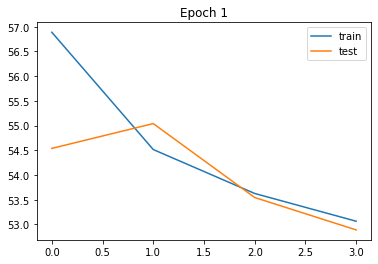

Start epoch 3
Epoch: 2 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 52.5310 1093.39s 
TEST Epoch 2 --- Loss: 52.0670 --- m_pr: 0.18 --- m_re: 0.62 --- m_f1: 0.27
Start epoch 4
Epoch: 3 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 52.1294 1091.98s 
TEST Epoch 3 --- Loss: 52.3429 --- m_pr: 0.17 --- m_re: 0.60 --- m_f1: 0.26


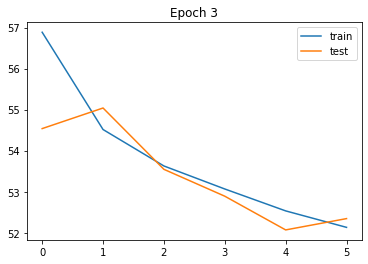

Start epoch 5
Epoch: 4 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 51.7232 1085.46s 
TEST Epoch 4 --- Loss: 52.1168 --- m_pr: 0.17 --- m_re: 0.61 --- m_f1: 0.27
Start epoch 6
Epoch: 5 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 51.3099 1085.72s 
TEST Epoch 5 --- Loss: 51.8205 --- m_pr: 0.17 --- m_re: 0.61 --- m_f1: 0.27


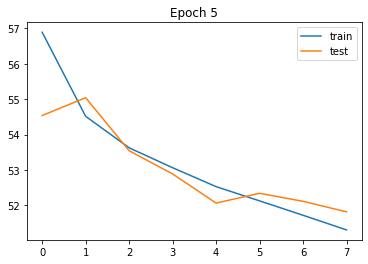

Start epoch 7
Epoch: 6 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 50.9928 1095.88s 
TEST Epoch 6 --- Loss: 52.0002 --- m_pr: 0.18 --- m_re: 0.62 --- m_f1: 0.27
Start epoch 8
Epoch: 7 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 50.4715 1083.51s 
TEST Epoch 7 --- Loss: 52.3897 --- m_pr: 0.17 --- m_re: 0.61 --- m_f1: 0.27


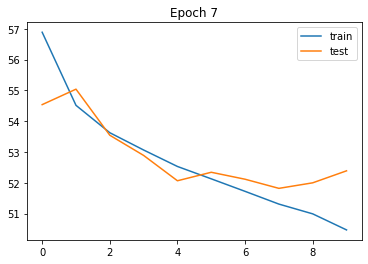

Start epoch 9
Epoch: 8 - 136/135 [---------------------------------------------------------------------------------------------------->] Loss: 50.4731 1089.02s 
TEST Epoch 8 --- Loss: 51.5589 --- m_pr: 0.18 --- m_re: 0.62 --- m_f1: 0.28
Start epoch 10
Epoch: 9 - 116/135 [-------------------------------------------------------------------------------------->.............] Loss: 46.3645 154.06s

In [ ]:
epochs = 30
train_losses = []

print_every = 2
save_every = 2

try:
    for epoch in range(0, epochs):
        print('Start epoch', epoch+1)        
        
        train_l = training(epoch,trailerClassifier)
        test_l = test_step_lab(trailerClassifier,criterion_lab,epoch)

        history['train'].append(train_l)
        history['test'].append(test_l)
        
        if (epoch + 1) % print_every == 0:
            plotLoss(epoch,history['train'],history['test'])

        if (epoch +1) % save_every==0:
            save_checkpoint(epoch,trailerClassifier,lab_optimizer,train_l,name=f"trailerClassifierSesemiAsym224Agum",optimizer2 = unlab_optimizer) 
except KeyboardInterrupt: 
    print('Exiting from training early')

# Test

In [ ]:
topk=10
predictions = []
y_true = []

trailerClassifier.eval()

with torch.no_grad():
    for inputs, labels in testDataLoader:
        inputs = inputs.to(device)

        y_pred = trailerClassifier(inputs)
        y_pred = torch.sigmoid(y_pred)

        _, idx = y_pred.topk(topk, dim=1)
        
        y_pred = torch.zeros_like(y_pred)
        y_pred.scatter_(1, idx, 1)
        
        predictions.append(y_pred.cpu())

        y_true.append(labels.cpu())


y_true, predictions = torch.cat(y_true, axis=0), torch.cat(predictions, axis=0)
report = classification_report(y_true, predictions, 
                               target_names=list(sorted(label_idx.keys())))
print(report)